In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from matplotlib import pyplot as plt
from model import BackBone

import numpy as np
import os
import json
import cv2
import imutils

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
class Pose_Dataset(Dataset):
    def __init__(self, annotations_path, img_path, transform = None):
        f = open(annotations_path, 'r')
        self.all_annotations = json.load(f)
        self.keypoints = self.all_annotations['annotations']
        f.close()
        self.annnotations_path = annotations_path
        self.img_path = img_path
        self.transform = transform
    def __len__(self):
        return len(self.keypoints)
    def __getitem__(self, idx):
        def form_gaussian_batch(sigma, kpts, img):
            batch = np.zeros((img.shape[0], img.shape[1], 17))
            for i in range(0,17):
                batch[:, :, i] = get_gaussian(img.shape, kpts[i, 0], kpts[i, 1], sigma)
            return batch
    
        def get_gaussian(output_shape, x, y, sigma):
            xx, yy= np.meshgrid(np.arange(output_shape[1]), np.arange(output_shape[0]))
            return ((1/(np.sqrt(2*np.pi*sigma**2)))*np.exp(-(yy-y)**2/(2*sigma**2)))*((1/(np.sqrt(2*np.pi*sigma**2)))*np.exp(-(xx-x)**2/(2*sigma**2)))
        
        if torch.is_tensor(idx):
            idx = idx.to_list()
        anns = self.keypoints[idx]
        image = cv2.imread(os.path.join(self.img_path, anns['image_name']))
        image = cv2.resize(image, (0,0), fx = 0.2, fy = 0.2)
        bbox = anns['bbox']
        cropped_img = image[bbox[1]:(bbox[1]+bbox[3]), bbox[0]:(bbox[0]+bbox[2])]
        
        kpts = np.array(anns['keypoints'], dtype = np.int32)
        kpts = np.reshape(kpts, (17,3))
        kpts[:, 0] = kpts[:, 0] - int(bbox[0])
        kpts[:, 1] = kpts[:, 1] - int(bbox[1])
        
        # now generate gaussian maps as target
        
        sigmas = [13, 9, 6, 3]
        target = []
        for sigma in sigmas:
            target.append(form_gaussian_batch(sigma, kpts, cropped_img))
        sample = {'image' : cropped_img, 'target' : target}
        
        if self.transform:
            sample = self.transform(sample)
        return sample


In [4]:
def my_collate(Batch):
    max_height, max_width = 0, 0
    useful_images = 0
    
    for item in Batch:
        image = item['image']
        if(image.shape[1] * image.shape[2] > 10000):
            useful_images += 1
        max_height = max(max_height, image.shape[1])
        max_width = max(max_width, image.shape[2])

    mini_batch = torch.zeros((useful_images, 3, max_height, max_width), device = device)
    mini_batch_target = torch.zeros((useful_images, 17*4, max_height, max_width), device = device)

    i = 0
    for item in Batch:
        if(i >= useful_images):
            break
        img = item['image']
        if(img.shape[1] * img.shape[2] < 10000):
            continue
        
        left_padding = (max_width-(img.shape[2]))//2
        top_padding = (max_height-(img.shape[1]))//2
        
        mini_batch[i, :, top_padding:(top_padding + img.shape[1]),left_padding:(left_padding + img.shape[2])] = img
        for j, batch in enumerate(item['target']):
            mini_batch_target[i, 17*j:(17*j+17), top_padding:(top_padding + img.shape[1]),left_padding:(left_padding + img.shape[2])] = batch
        i += 1

    return [mini_batch, mini_batch_target]


In [5]:
class RandomFlip(object):
    def __init__(self, p):
        self.p = p
    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        if(np.random.random_sample() > self.p):
            flipped_image = cv2.flip(image, 1)
            flipped_target = []
            for batch in target:
                flipped_batch = np.zeros(batch.shape)
                for i in range(0, 17):
                    flipped_batch[:, :, i] = cv2.flip(batch[:, :, i], 1)
                corrected_batch = np.zeros(batch.shape)
                corrected_batch[:, :, 0] = flipped_batch[:, :, 0]
                for j in range(1, 9):
                    corrected_batch[:, :, ((2*j) -1)] = flipped_batch[:, :, (2*j)]
                    corrected_batch[:, :, (2*j)] = flipped_batch[:, :, ((2*j) -1)]
                flipped_target.append(corrected_batch)
            return {'image' : flipped_image, 'target' : flipped_target}
        return sample


In [6]:
class RandomRotate(object):
    def __init__(self, degree):
        self.degree = degree
    def __call__(self, sample):
        image, target = sample['image'], sample['target']
        angle = np.random.random_sample()*self.degree
        angle = angle if (np.random.random_sample() > 0.5) else (-1 * angle)
        rotated_image = imutils.rotate_bound(np.float32(image)/255, angle = angle)
        rotated_target = []
        for batch in target:
            h, w = imutils.rotate_bound(np.float32(batch[:, :, 0]), angle = angle).shape
            rotated_batch = np.zeros((h, w, 17))
            for i in range(0, 17):
                rotated_batch[:, :, i] = imutils.rotate_bound(np.float32(batch[:, :, i]), angle = angle)
            rotated_target.append(rotated_batch)
        return {'image' : rotated_image, 'target' : rotated_target}


In [7]:
class ToTensor(object):
    def __call__(self, sample):
        image, targets = sample['image'], sample['target']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        tensor_targets = []
        for batch in targets:
            tensor_targets.append(torch.from_numpy(np.transpose(batch, (2, 0, 1)))) 
        return {'image': image,
                'target': tensor_targets}

Shape of image batch is : torch.Size([7, 3, 381, 282])
Shape of target batch is : torch.Size([7, 68, 381, 282])
Type of image is : torch.cuda.FloatTensor
Type of target is : torch.cuda.FloatTensor


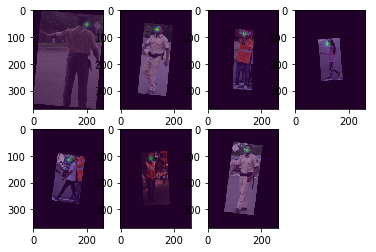

In [8]:
if __name__ == '__main__':
    
    pose_keypoints = Pose_Dataset(annotations_path = 'Data/annotations/vru_keypoints_val_copy.json',
                      img_path = 'Data/images/val',
                      transform = transforms.Compose([
                          RandomFlip(0.5),
                          RandomRotate(degree = 10),
                          ToTensor()
                      ]))
    
    train_loader = DataLoader(pose_keypoints, batch_size = 16, shuffle = False, collate_fn = my_collate
                             )
    for image, target in train_loader:
        print("Shape of image batch is :",image.shape)
        print("Shape of target batch is :",target.shape)
        print("Type of image is :", image.type())
        print("Type of target is :", target.type())

    iterator = iter(train_loader)
    image, target = next(iterator)

    axes = []
    fig = plt.figure()
    for i in range(image.shape[0]):
        img = np.transpose(image[i].cpu(), (1, 2, 0))
        axes.append(fig.add_subplot(2, 4, i+1))
    #     axes[-1].set_title("image :", i)
        plt.imshow(img[:, :, [2, 1, 0]])
        plt.imshow(target[i][34].cpu(), alpha = 0.5)
    # fig.tight_layout()
    plt.show()

#     #--------------------------------------------------------------------------------------------------------------------------

#     batch_data = next(iter(train_loader))
#     img = batch_data['image'][1]
#     #--------------------------------------------------------------------------------------------------------------------------
#     plt.imshow(np.transpose(img, (1,2,0))[:, :, [2, 1, 0]])
#     anno = batch_data['target'][1][0][:, :, 16]
#     plt.imshow(anno, alpha = 0.5)
#     #--------------------------------------------------------------------------------------------------------------------------

#     model = BackBone().cuda()
#     summary(model, (3, 269, 117))

#     data = iter(train_loader).next()
#     images = data['image']
#     # print(type(images[0]))
# #     writer = SummaryWriter('runs/experiment1')
# #     writer.add_graph(model, images[0][None, : , :, :].to('cuda'))
# #     writer.close()